# **Project**: Maze Rider

**Expectation:**

For this project, we require you to do two things:
1. Answer the two questions that you will find below. These questions consist in implementing from scratch both a _Model free tabular RL agent_ and a _Deep Reinforcement Learning_ agent on a relatively simple maze environment.
2. Write a **short** report (2 pages maximum) on your findings, which algorithm worked best, what hyperparameters where key, what hyperparameters were useless.

The following requirements must be met for each projects:
- The deadline for the project is on FRIDAY 3 MARCH. You should send us a mail with your project attached as a zip before sunday, midnight. Any additional day over the deadline will reduce the final grade by 2 points. Monday 00:01am counts as one day over the deadline.
- Projects should be done in groups of 5, and the following [spreadsheet](https://docs.google.com/spreadsheets/d/1YsgkQwBu1Y-A-y4Bf9JVpy0q4nqI4cOvQkS4LKjnLNg/edit?usp=sharing) should be filled to notify us of the groups.
- You can rely as much as you want on the previous practicals, including by copying chunks of code.
- You cannot share code with other groups. Any suspicion of code plagiarism will result in us halving the grade for both groups.

In [ ]:
#@title Installation
!pip install chex
!pip install jax
!pip install optax
!pip install dm-acme
!pip install dm-acme[reverb]
#!pip install dm-acme[jax]
!pip install dm-acme[tf]
!pip install dm-acme[envs]
!pip install dm-env
!pip install dm-haiku
!pip install imageio
!pip install gym

from IPython.display import clear_output
clear_output()

In [ ]:
#@title Imports
import sys
import numpy as np
import matplotlib.pyplot as plt
import json
import math
import time
import numpy as np
from gym import utils
import enum
from typing import *
import chex
from dataclasses import dataclass, asdict

# Environment

For this project, our environment will be a maze. The idea is pretty simple: our agent starts at one end of the maze and must reach a certain goal at the other end. To make things spicier, the agent must also avoid pits scattered in the environment.

At each step the agent can perform one of this four actions: move to the left, to the right, up or down:
- If the agent reaches an empty cell, it gets a reward of $0$.
- If the agent tries to cross a wall, nothing happens and it also gets a reward of $0$.
- If the agent reaches the goal, the episode ends and it gets a reward of $1$.
- If the agent falls into a pit, the episode ends and it gets a reward of $-1$.

The walls will stay the same between each episode, however, the agent's starting position as well as the positions of the goal and the pits will be randomly picked between a small number of candidates at each episode.

In [ ]:
# @title **[Skip]** Environment implementation details

TXT_TEMPLATE = """
#######  #######
# SSS #  #PGGGP#
### ###  ##P P##
  # ######## #
  #          #
  ############
---
S=0
G=0
P=.5
"""

BIG_MAZE = """
#########################################
#SSS#     #PPP#S#      #         #G   PP#
#   #GP       # #####  #P  #     #      #
#   ####  #   # #G     #   #GGGGGGGGG   #
#      GGG#   # #      #   ###########  #
###########         #      #            #
#G        #PP     GGGGGG#GG###S      GGG#
#PP  P#   ##################    #########
#######   #      #P                     #
#G               G      #S      P#      #
#########################################
---
S=0
G=0
P=0.5
"""

class CellType(enum.IntEnum):
  WALL = enum.auto()
  PLAYER = enum.auto()
  GOAL = enum.auto()
  PIT = enum.auto()
  EMPTY = enum.auto()

TYPE_TO_CHAR = {
      CellType.WALL: '#',
      CellType.PLAYER: 'S',
      CellType.GOAL: 'G',
      CellType.PIT: 'P',
      CellType.EMPTY: ' ',
  }

def process_template(txt_template: str) -> Tuple[chex.Array, Mapping[str, float]]:
  char_to_type = {v: k for k, v in TYPE_TO_CHAR.items()}
  maze_template, maze_info = txt_template.split("---")
  grid = maze_template.split('\n')
  grid = [l for l in grid if l]
  n_lines, n_cols = len(grid), max(map(len, grid))
  grid = [l + ' ' * (n_cols - len(l)) for l in grid]
  grid = np.array(list(map(lambda x: list(x), grid)))
  mask_pattern = np.array([' '] * len(CellType))
  for k, v in TYPE_TO_CHAR.items():
    mask_pattern[k.value - 1] = v

  grid = grid[:, :, None] == mask_pattern[None, None]
  maze_infos = [list(map(lambda x: x.strip(' '), x.split('='))) for x in maze_info.split('\n') if x]
  maze_infos = {char_to_type[k]: float(v) for k, v in maze_infos}
  return grid, maze_infos

def sample_grid(grid: chex.Array, maze_infos: Mapping[str, float]) -> chex.Array:
  sample = grid.copy()
  for k, v in maze_infos.items():
    layer = grid[..., k.value - 1]
    if v > 0.:
      mask = np.random.binomial(1, v, size=layer.shape)
      sample[..., k.value - 1] = mask * layer
    else:
      idxs = np.nonzero(layer)
      i = np.random.randint(idxs[0].shape[0])
      sample[..., k.value - 1] = np.zeros_like(sample[..., k.value - 1])
      sample[..., k.value - 1][idxs[0][i], idxs[1][i]] = 1

  # For cells that have no values, fill the space layer with 1
  sample[..., CellType.EMPTY.value - 1] = np.maximum(np.all(sample == 0, axis=-1), sample[..., CellType.EMPTY.value - 1])
  return sample

def to_string(grid: chex.Array) -> str:
  mask_pattern = np.array([' '] * len(CellType))
  for k, v in TYPE_TO_CHAR.items():
    mask_pattern[k.value - 1] = v
  str_grid = mask_pattern[grid.argmax(axis=-1)]
  str_grid = '\n'.join(map(lambda x: ''.join(x), str_grid))
  return str_grid

Read the following definition of the `Maze` environment, so that you get an idea of what you have access to in the environment.

In [ ]:
# @title **[Read]** Environment definition

class Maze:
  """Definition of the Maze environment.

  You do not need to read this class implementation in detail, you should
  just have a look at its different methods, to see what properties of the
  environment you can access.
  """
  def __init__(self, txt_template: str) -> None:
    self._grid_template, self._maze_infos = process_template(txt_template)

  def reset(self) -> chex.Array:
    """Resets the environment."""
    self._grid = sample_grid(self._grid_template, self._maze_infos)
    return self._grid

  def step(self, action: int) -> Tuple[chex.Array, float, bool]:
    """Perfoms one step in the environment.

    Args:
      action: index of the action to perform.
    Returns:
      next_state, reward, done

    next_state: next state of the environment.
    reward: reward of the current step.
    done: if True the game has ended.
    """
    n_rows, n_cols, _ = self._grid.shape
    x, y = np.nonzero(self._grid[..., CellType.PLAYER.value - 1])
    x, y = x[0], y[0]
    next_x, next_y = x, y
    if action == 0:
      next_x = max(min(x + 1, n_rows - 1), 0)
    elif action == 1:
      next_x = max(min(x - 1, n_rows - 1), 0)
    elif action == 2:
      next_y = max(min(y + 1, n_cols - 1), 0)
    elif action == 3:
      next_y = max(min(y - 1, n_cols - 1), 0)
    next_cell_type = CellType(self._grid[next_x, next_y].argmax() + 1)
    if next_cell_type is CellType.WALL:
      next_x, next_y = x, y
      reward = 0.
      done = False
    elif next_cell_type is CellType.EMPTY:
      reward = 0.
      done = False
    elif next_cell_type == CellType.PIT:
      reward = -1.
      done = True
    elif next_cell_type == CellType.GOAL:
      reward = 1.
      done = True
    else:
      raise ValueError(f'Unknown next cell type {next_cell_type}, this should not happen.')
    self._grid[..., CellType.PLAYER.value - 1][x, y] = 0
    self._grid[..., CellType.EMPTY.value - 1][x, y] = 1
    self._grid[..., :][next_x, next_y] = 0
    self._grid[..., CellType.PLAYER.value - 1][next_x, next_y] = 1
    return self._grid, reward, done

  def render(self) -> str:
    """Renders the environment as a string."""
    return to_string(self._grid)

  def num_actions(self) -> int:
    """Returns the number of usable actions."""
    return 4

  def obs_shape(self) -> Tuple[int, int]:
    """Returns the shape of the Maze."""
    return self._grid.shape

Use the following cell to interact manually with the environment: launch it and a small command line will appear. The commands **U**, **D**, **L** and **R** will move the agent `S`, try to reach the goal `G` by hand while avoiding the eventual pits `P`.

If, for some reason, you want to stop the episode before its end just enter **STOP** into the command line.

In [ ]:
#@title **[Play with the environment]**
env = Maze(TXT_TEMPLATE)

env.reset()

action_to_int = {
    'D': 0,
    'U': 1,
    'R': 2,
    'L': 3,
}

# To stop the game, enter this command
STOP_GAME = 'STOP'

while True:
  print(env.render())
  while True:
    action = input().upper()
    if action in ['U', 'D', 'L', 'R', STOP_GAME]:
      break
  if action == STOP_GAME:
    break
  _, reward, done = env.step(action_to_int[action])
  print(f'-----\nReward: {reward}\n-----\n')
  if done:
    break

#######  #######
#   S #  # G  P#
### ###  ##P  ##
  # ######## #  
  #          #  
  ############  
STOP


In [ ]:
environment = Maze(TXT_TEMPLATE)
state = environment.reset()
print(state.shape)
print(state[:, :, 3])

(6, 16, 5)
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False  True
  False  True False False]
 [False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]


# **[Exercice 1]** Implementing a tabular RL Algorithm.

Your first task is to implement a model free tabular RL algorithm for the maze environment. You can go for either Q-learning or SARSA. Feel free to take inspiration from the other practicals.

## Hashing
As in the DQN practical, the environment state is a `chex.Array`, and it can thus not directly be put in a dictionary. As in this practical, you should implement a `numpy_to_hash` function.

This function should transform each state into something that can be used as a key in a dictionary. Additionally, this function should be invertible (each input is uniquely mapped to one unique output). In other word, this function should not lose any information. Think about all the information that are contained in a state (position of the agent, position of the goal, ...) and try to encode them in a hash in a compact way.

Contrary to what was done in the DQN practical, you do not need to implement a `hash_to_numpy` function that is the inverse of `np_to_hash`.

## Agent API
Your agent must implement the following functions:
- `def act(self, state: chex.Array, eval: bool = False) -> int` a function that takes in an observation and returns the action selected by the agent. `eval=True` means that you should use the learnt policy, `eval=False` means that you should use the acting policy. Depending on your choice of agent, these two policies may or may not differ.
- `def update(self, state: chex.Array, action: int, next_state: chex.Array, reward: float, done: bool) -> None:` a function that takes in a transition and updates the agent policy.


In [ ]:
def numpy_to_hash(x: chex.Array) -> str:
    return x.tobytes()

def hash_to_numpy(h: str, env: Maze) -> chex.Array:
  return np.frombuffer(h).reshape(env.obs_shape())

In [ ]:
# @title **[Implement]** Define your agent
class Agent:
  def __init__(self, env, gamma, epsilon, alpha, default_qvalue=0):
    self._Na = env.num_actions()
    self._gamma = gamma
    self._epsilon = epsilon
    self._alpha = alpha
    self._default_qvalue = default_qvalue
    self.q_values = dict()

  def act(self, state: chex.Array, eval: bool = False) -> int:
    s = numpy_to_hash(state)
    if (not eval and np.random.rand() < self._epsilon) or s not in self.q_values:
      return np.random.randint(self._Na)
    
    return np.argmax(self.q_values[s])
    

  def update(self, state: chex.Array, action: int, next_state: chex.Array, reward: float, done: bool) -> None:
    
    s1 = numpy_to_hash(state)
    if s1 not in self.q_values:
      self.q_values[s1] = np.ones((self._Na,)) * self._default_qvalue

    s2 = numpy_to_hash(next_state)
    if s2 not in self.q_values:
      self.q_values[s2] = np.ones((self._Na,)) * self._default_qvalue

    next_value = np.max(self.q_values[s2]) if not done else 0
    self.q_values[s1][action] += self._alpha * (reward + self._gamma * next_value - self.q_values[s1][action]) 

We went for a Q-Learning procedure. The chosen Maze is the little one as then the space and actions space is small enough to justify tabular RL.

Episode number:	| Average reward on 100 eval episodes
------------------------------------------------------
	0	|	-0.3
	10	|	0.0
	20	|	-0.1
	30	|	0.2
	40	|	0.2
	50	|	-0.1
	60	|	0.3
	70	|	0.0
	80	|	0.0
	90	|	0.1
	100	|	0.1
	110	|	0.0
	120	|	-0.1
	130	|	0.0
	140	|	0.0
	150	|	0.0
	160	|	0.0
	170	|	0.0
	180	|	0.0
	190	|	0.0
	200	|	0.0
	210	|	0.0
	220	|	0.0
	230	|	0.0
	240	|	0.0
	250	|	0.0
	260	|	0.0
	270	|	0.0
	280	|	0.0
	290	|	0.0
	300	|	0.0
	310	|	0.0
	320	|	0.0
	330	|	0.0
	340	|	0.0
	350	|	0.0
	360	|	0.0
	370	|	0.0
	380	|	0.0
	390	|	0.0
	400	|	0.0
	410	|	0.0
	420	|	0.0
	430	|	0.0
	440	|	0.0
	450	|	0.0
	460	|	0.0
	470	|	0.1
	480	|	0.0
	490	|	0.0
	500	|	0.0
	510	|	0.1
	520	|	0.0
	530	|	0.0
	540	|	0.3
	550	|	0.0
	560	|	0.1
	570	|	0.0
	580	|	0.0
	590	|	0.1
	600	|	0.1
	610	|	0.2
	620	|	0.2
	630	|	0.1
	640	|	0.2
	650	|	0.1
	660	|	0.3
	670	|	0.1
	680	|	0.1
	690	|	0.2
	700	|	0.3
	710	|	0.2
	720	|	0.2
	730	|	0.4
	740	|	0.2
	750	|	0.3
	760	|	0.4
	770	|	0.1
	780	|	0.2
	790	|	0.1
	800	|	0.1
	810	|	

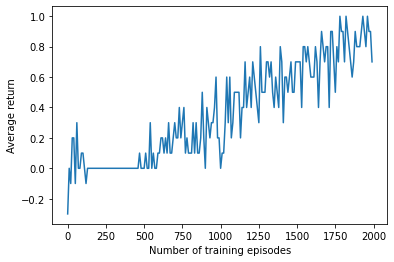

In [ ]:
# @title **[Fill]** Run your agent
import matplotlib.pyplot as plt

num_episodes = 2000
num_eval_episodes = 10
eval_every_N = 10

environment = Maze(TXT_TEMPLATE)
# environment = Maze(BIG_MAZE)
Na = environment.num_actions()

gamma = 0.99
epsilon = 0.5
alpha = 0.01
default_qvalue = 0

# [DEFINE YOUR AGENT HERE]
agent = Agent(environment, gamma, epsilon, alpha, default_qvalue)
all_rewards = []
episodes = []

def run_episode(agent: Agent, env: Maze, eval: bool, max_steps: int = 1000, render: bool = False) -> float:
  # Reset any counts and start the environment.
  state = environment.reset()
  n_steps = 0

  # Run an episode.
  while True:
    if render:
      print(f'Step: {n_steps}')
      print(environment.render())

    # Generate an action from the agent's policy and step the environment.
    action = agent.act(state, eval=eval)
    next_state, reward, done = environment.step(action)
    if not eval:
      agent.update(state, action, next_state, reward, done)
    n_steps += 1

    state = next_state.copy()
    if done or n_steps > max_steps:
      break

  return reward

print("Episode number:\t| Average reward on 100 eval episodes")
print("------------------------------------------------------")

for episode in range(num_episodes):
  run_episode(agent, environment, eval=False)

  if episode % eval_every_N == 0:
    reward = np.mean([run_episode(agent, environment, eval=True) for _ in range(num_eval_episodes)])
    print(f"\t{episode}\t|\t{reward}")
    all_rewards.append(reward)
    episodes.append(episode)

plt.xlabel('Number of training episodes')
plt.ylabel('Average return')
plt.plot(episodes, all_rewards)

In [ ]:
# @title **[Run]** Visualize one trajectory for your agent.
run_episode(agent, environment, eval=True, render=True)

# **[Exercice 2]** Implementing a deep RL Algorithm.

Your second (harder) task is to implement a _Deep RL algorithm_ for the maze environment. You can go for either DQN or a variant of policy gradient of your choice. Again, feel free to take inspiration from the other practicals.

## Agent API
Your agent must implement the following functions:
- `def act(self, state: chex.Array, eval: bool = False) -> int` a function that takes in an observation and returns the action selected by the agent. `eval=True` means that you should use the learnt policy, `eval=False` means that you should use the acting policy. Depending on your choice of agent, these two policies may or may not differ.
- ` def first_observe(self, state: chex.Array) -> None:` a function that takes care of handling the first observation obtained after a reset. This function can notably memorize the first state, so that when we call observe, we have a full transition `(state, action, reward, done, next_state)` at our disposal.
- `def observe(self, action_t: chex.Array, reward_t: chex.Array, done_t: chex.Array, state_tp1: chex.Array) -> chex.Array:` a function that takes an action, a reward, a termination signal and a next state, and performs any update required by our agent to update its policy. To make things much easier, you should look at what this function is doing for the implementation in the DQN practical.

#Imports for Deep RL

In [ ]:
import haiku as hk
import jax
import jax.numpy as jnp
import optax

#Logging with wandb

In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 20.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.4 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=a71c70fc2562bafadf445d022fb8d349f5e4a90d307f65a04c813c5b3dae363a
  Stored in directory: /root/.cache/pip/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be004
Successfully built pathtools


In [ ]:
import wandb
WANDB_API_KEY = 'aaac06fd950730949910d815f40a98c430390a0b'
wandb.login(key=WANDB_API_KEY)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
project_name = "deeprl_project_1"

# Getting the optimal trajectories

As the maze is quite big, it is nearly impossible for an untrained model to stumble by chance upon the goal with a reasonable number of steps, so convergence was nearly impossible.

Fortunately solving the shortest path between the start and the goal is a problem for which we have exact algorithm. Thus we tried to guide the model by feeding him the optimal action at each step.

The following function (Breadth First Search) computes a correct shortest path.

In [ ]:
def bfs(grid : chex.Array):
  m, n, _ = grid.shape
  next = [[[None for action in range(env.num_actions())] for y in range(n)] for x in range(m)]
  #construction of the adjency matrix:
  for x in range(m):
    for y in range(n):
      #pass if wall, pit, or goal
      if grid[..., CellType.WALL.value - 1][x, y] or grid[..., CellType.PIT.value - 1][x, y] or grid[..., CellType.GOAL.value - 1][x, y]:
        continue
      #it means it is an empty cell, maybe the player is on it
      for action in range(env.num_actions()):
        next_x, next_y = x, y
        if action == 0:
          next_x = max(min(x + 1, m - 1), 0)
        elif action == 1:
          next_x = max(min(x - 1, m - 1), 0)
        elif action == 2:
          next_y = max(min(y + 1, n - 1), 0)
        elif action == 3:
          next_y = max(min(y - 1, n - 1), 0)

        if grid[..., CellType.WALL.value - 1][next_x, next_y] or grid[..., CellType.PIT.value - 1][next_x, next_y]:
          next_x, next_y = x, y
        next[x][y][action] = (next_x, next_y)
  
  xp, yp = np.nonzero(grid[..., CellType.PLAYER.value - 1])
  xp, yp = xp[0], yp[0]
  xg, yg = np.nonzero(grid[..., CellType.GOAL.value - 1])
  xg, yg = xg[0], yg[0]

  queue = [(xp, yp)]
  treated = [[False for y in range(n)] for x in range(m)]
  father = [[None for y in range(n)] for x in range(m)]
  while queue and not(x == xg and y == yg):
    x, y = queue.pop(0)
    for action in range(env.num_actions()):
      if next[x][y][action] is None:
        continue
      next_x, next_y = next[x][y][action]
      if not treated[next_x][next_y]:
        treated[next_x][next_y] = True
        father[next_x][next_y] = (x, y, action)
        queue.append((next_x, next_y))

  #getting the optimal actions
  optimal_actions = [[None for y in range(n)] for x in range(m)]
  x, y = xg, yg
  while not(x == xp and y == yp):
    prev_x, prev_y, action = father[x][y]
    optimal_actions[prev_x][prev_y] = action
    x, y = prev_x, prev_y
  
  return optimal_actions, next

#Replay Buffer for DQN

In [ ]:
@chex.dataclass
class Transition:
  state_t: chex.Array
  action_t: chex.Array
  reward_t: chex.Array
  done_t: chex.Array
  state_tp1: chex.Array


class ReplayBuffer:
  """Fixed-size buffer to store transition tuples."""

  def __init__(self, buffer_capacity: int):
      """Initialize a ReplayBuffer object.
      Args:
          batch_size (int): size of each training batch
      """
      self._memory = list()
      self._maxlen = buffer_capacity

  @property
  def size(self) -> int:
    # Return the current number of elements in the buffer.
    return len(self._memory)

  def add(self, state_t: chex.Array,
          action_t: chex.Array,
          reward_t: chex.Array,
          done_t: chex.Array,
          state_tp1: chex.Array) -> None:
      """Add a new transition to memory."""

      if self.size > self._maxlen:
          self._memory = self._memory[1:]
      
      self._memory.append(Transition(state_t=state_t,
                              action_t = action_t,
                              reward_t = reward_t,
                              done_t = done_t,
                              state_tp1 = state_tp1))

  def sample(self) -> Transition:
      """Randomly sample a transition from memory."""
      assert self._memory, 'replay buffer is unfilled'

      index = np.random.randint(self.size)
      return self._memory[index]


In [ ]:
class BatchedReplayBuffer(ReplayBuffer):

  def sample_batch(self, batch_size) -> Transition:
    """Randomly sample a batch of experiences from memory."""
    assert len(self._memory) >= batch_size, 'Insuficient number of transitions in replay buffer'
    # Your code here !
    samples = [self.sample() for i in range(batch_size)]
    kwargs = dict()
    for attr in ["state_t", "action_t", "reward_t", "done_t", "state_tp1"]:
        kwargs[attr] = np.array([getattr(s, attr) for s in samples])
    return Transition(**kwargs)

# Prioritized Experience Replay

In [ ]:
class PrioritizedReplayBuffer:
  """Fixed-size buffer to store transition tuples."""

  def __init__(self, buffer_capacity: int, alpha: float = 0.4, beta: float = 0.6 , epsilon: float = 1e-6 ):
      """Initialize a ReplayBuffer object.
      Args:
          batch_size (int): size of each training batch
      """
      self._memory = list()
      self._maxlen = buffer_capacity
      self._alpha = alpha
      self._beta = beta
      self._epsilon = epsilon
      self._index = 0
      self._priorities = np.zeros(buffer_capacity, dtype=np.float32)

  @property
  def size(self) -> int:
    # Return the current number of elements in the buffer.
    return len(self._memory)

  def add(self, state_t: chex.Array,
          action_t: chex.Array,
          reward_t: chex.Array,
          done_t: chex.Array,
          state_tp1: chex.Array,
          priority: chex.Array) -> None:
      """Add a new transition to memory."""

      if self.size < self._maxlen:
        self._memory.append(Transition(state_t=state_t,
                                action_t = action_t,
                                reward_t = reward_t,
                                done_t = done_t,
                                state_tp1 = state_tp1))
      else:
        self._memory[self._index] = Transition(state_t=state_t,
                                action_t = action_t,
                                reward_t = reward_t,
                                done_t = done_t,
                                state_tp1 = state_tp1)
      self._priorities[self._index] = priority
      self._index = (self._index + 1) % self._maxlen

  def sample_batch(self, batch_size) -> Transition:
      """Randomly sample a transition from memory."""
      assert self._memory, 'replay buffer is unfilled'
      assert len(self._memory) >= batch_size, 'Insuficient number of transitions in replay buffer'

      priorities = self._priorities[:len(self._memory)]
      probabilities = priorities ** self._alpha
      probabilities /= probabilities.sum()
      indices = np.random.choice(len(self._memory), batch_size, p=probabilities)
      samples = [self._memory[i] for i in indices]
      weights = (len(self._memory) * probabilities[indices]) ** (-self._beta)
      weights /= weights.max()
      weights = np.array(weights, dtype=np.float32)

      kwargs = dict()
      for attr in ["state_t", "action_t", "reward_t", "done_t", "state_tp1"]:
          kwargs[attr] = np.array([getattr(s, attr) for s in samples])
      return Transition(**kwargs), indices, weights
    

  def update_priorities(self, indices, priorities):
      for i, p in zip(indices, priorities):
          self._priorities[i] = abs(p) + self._epsilon

# Training Config

In [ ]:
@dataclass()
class TrainingConfig:
  num_episodes : int = 15000
  num_eval_episodes : int = 20
  eval_every_N : int = 10
  gamma : float = 0.9
  eps : float = 1.0
  eps_decay_per_episode : float = 0.9995
  min_eps : float = 0.1
  learning_rate : float = 1e-3
  buffer_capacity : int = 5000
  min_buffer_capacity : int = 64
  batch_size: int = 64
  target_ema=0.75
  seed : int = 0
  max_steps : int = 500
  update_every = 50

  probability_optimal = 0.9
  probability_optimal_decay = 1


# !! Please run only the cells for the selected method (Deep Q-Learning, Reinforce or A2C)

#Deep Q-Learning

In [ ]:
@chex.dataclass
class LearnerState:
  online_params: hk.Params
  target_params: hk.Params
  opt_state: optax.OptState

class DeepAgent:

  def __init__(
      self,
      env: Maze,
      network : callable,
      cfg : TrainingConfig,
      ) -> None:
    """Initializes the DQN agent.

    Args:
      env: Maze.
      gamma: discount factor
      eps: probability to perform a random exploration when picking a new action.
      learning_rate: learning rate of the online network
      buffer_capacity: capacity of the replay buffer
      min_buffer_capacity: min buffer size before picking batches from the
        replay buffer to update the online network
      batch_size: batch size when updating the online network
      target_ema: weight when updating the target network.
      seed: seed of the random generator.
    """
    self._env = env
    self._learning_rate = cfg.learning_rate
    self._eps = cfg.eps
    self._gamma = cfg.gamma
    self._batch_size = cfg.batch_size
    self._target_ema = cfg.target_ema
    self._Na = env.num_actions()
    self._network = network
    self._steps = 0
    self._update_every = cfg.update_every

    # Define the neural network for this agent
    self._init, self._apply = hk.without_apply_rng(hk.transform(self._hk_qfunction))
    # Jit the forward pass of the neural network for better performances
    self.apply = jax.jit(self._apply)

    # Also jit the update functiom
    self._update_fn = jax.jit(self._update_fn)

    # Initialize the network's parameters
    self._rng = jax.random.PRNGKey(cfg.seed)
    self._rng, init_rng = jax.random.split(self._rng)
    self._learner_state = self._init_state(init_rng)

    # Initialize the replay buffer
    self._min_buffer_capacity = cfg.min_buffer_capacity
    #self._buffer = BatchedReplayBuffer(cfg.buffer_capacity)
    self._buffer = BatchedReplayBuffer(cfg.buffer_capacity)

    # Build a variable to store the last state observed by the agent
    self._state = None

    #best params
    self._best_params = None

  def _optimizer(self) -> optax.GradientTransformation:
    return optax.adam(learning_rate=self._learning_rate)

  def _hk_qfunction(self, state: chex.Array) -> chex.Array:
    return self._network(state, self._env)

  def first_observe(self, state: chex.Array) -> None:
    self._state = state

  def _init_state(self, rng: chex.PRNGKey) -> LearnerState:
    """Initialize the online parameters, the target parameters and the
    optimizer's state."""

    #dummy step for the network to infer the input shape
    dummy_step = self._env.reset().copy()[None]

    #split the rng to have a different stochasticity between the target and the online parameters
    online_rng, target_rng = jax.random.split(rng)

    #initializing the parameters and the optimizer
    online_params = self._init(online_rng, dummy_step)
    target_params = self._init(target_rng, dummy_step)
    opt_state = self._optimizer().init(online_params)


    return LearnerState(
        online_params = online_params,
        target_params = target_params,
        opt_state = opt_state,
    )
  
  def act(self, state: chex.Array, eval: bool = False, explore: bool = False) -> int:
    #if not in eval mode or explore mode we might do some exploration
    if not eval and (explore or np.random.uniform() < self._eps):
      return np.random.randint(self._Na)

    #returning the greedy action
    online_params = self._learner_state.online_params
    return jnp.argmax(self.apply(online_params, state[None]), axis=-1).item()

  def loss_fn(
      self,
      online_params: hk.Params,
      target_params: hk.Params,
      state_t: chex.Array,
      action_t: chex.Array,
      reward_t: chex.Array,
      done_t: chex.Array,
      state_tp1: chex.Array,
      ) -> chex.Array:
      """Computes the Q-learning loss

      Args:
        online_params: parameters of the online network
        target_params: parameters of the target network
        state_t: batch of observations at time t
        action_t: batch of actions performed at time t
        reward_t: batch of rewards obtained at time t
        done_t: batch of end of episode status at time t
        state_tp1: batch of states at time t+1
      Returns:
        The Q-learning loss.
      """
      
      targets = reward_t + self._gamma * jnp.max((1 - done_t[..., None]) * self.apply(target_params, state_tp1), axis=1)
      predictions = self.apply(online_params, state_t)
      predictions = jax.vmap(lambda pred, action : pred[action])(predictions, action_t)
      loss = jnp.mean(jnp.square(predictions-targets))
      return loss
  
  def _update_fn(self,
                 state: LearnerState,
                 batch: Transition,
                 ) -> Tuple[chex.Array, LearnerState]:
    """Get the next learner state given the current batch of transitions.

    Args:
      state: learner state before update.
      batch: batch of experiences (st, at, rt, done_t, stp1)
    Returns:
      loss, learner state after update
    """

    # Compute gradients
    online_params = state.online_params
    target_params = state.target_params
    loss, grads = jax.value_and_grad(self.loss_fn)(online_params, 
                                                             target_params, 
                                                             batch.state_t, 
                                                             batch.action_t,
                                                             batch.reward_t,
                                                             batch.done_t,
                                                             batch.state_tp1)

    # Apply gradients
    opt_state = state.opt_state
    updates, opt_state = self._optimizer().update(grads, opt_state)
    online_params = optax.apply_updates(online_params, updates)
    

    # Update target network params as:
    # target_params <- ema * target_params + (1 - ema) * online_params
    
    target_params = jax.tree_map(lambda x, y : self._target_ema * x + (1 - self._target_ema) * y, target_params, online_params)
    
    next_state = LearnerState(online_params=online_params,
                              target_params=target_params,
                              opt_state=opt_state)
    return loss, next_state
  
  def _temporal_differences(self,
                  batch : Transition
                  ) -> chex.Array:
    """We have a batch of transition on which we want to compute their temporal difference w.r.t.
    the current online and target network
    """
    
    state_t = batch.state_t
    action_t = batch.action_t
    reward_t = batch.reward_t
    done_t = batch.done_t
    state_tp1 = batch.state_tp1

    online_params = self._learner_state.online_params
    target_params = self._learner_state.target_params
    targets = reward_t + self._gamma * jnp.max((1 - done_t[..., None]) * self.apply(target_params, state_tp1), axis=1)
    predictions = self.apply(online_params, state_t)
    predictions = jax.vmap(lambda pred, action : pred[action])(predictions, action_t)

    td = targets - predictions
    return td
      
  def observe(self,
              action_t: chex.Array,
              reward_t: chex.Array,
              done_t: chex.Array,
              state_tp1: chex.Array,
              ) -> chex.Array:
    """Updates the agent from the given observations.

    Args:
      action_t: action performed at time t.
      reward_t: reward obtained after having performed action_t.
      done_t: whether or not the episode is over after performing action_t.
      state_tp1: state at which the environment is at time t+1.
    Returns:
      DQN loss obtained when updating the online network.
    """

    #compute the priority associated with the transition. p = |td_error|

    """priority = self._priorities(Transition(state_t = self._state[None], 
                                           action_t = np.array([action_t]), 
                                           reward_t = np.array([reward_t]), 
                                           done_t = np.array([done_t]), 
                                           state_tp1 = state_tp1[None]))[0]"""
    self._buffer.add(self._state, action_t, reward_t, done_t, state_tp1) #priority)
    self._state = state_tp1

    # We update the agent if and only if we have enough states stored in
    # memory.
    if self._buffer.size >= self._min_buffer_capacity and self._steps % self._update_every == 0:
      batch = self._buffer.sample_batch(self._batch_size)
      #priorities = self._priorities(batch)
      #self._buffer.update_priorities(indices, priorities)
      loss, self._learner_state = self._update_fn(self._learner_state, batch)
      return loss
    self._steps += 1
    return None

  def decay_epsilon(self) -> None:
    self._eps = max(cfg.min_eps, cfg.eps_decay_per_episode * self._eps)
    cfg.eps = self._eps
  
  def save_checkpoint(self) -> None:
    self._best_params = self._learner_state.online_params

# Reinforce


In [ ]:
def cumulative_returns(rewards: chex.Array,
                       dones: chex.Array,
                       gamma: float,
                       ) -> chex.Array:
  returns = [0.]
  belongs_to_an_unfinished_episode = [1.]
  for r, d in zip(rewards[::-1], dones[::-1]):
    returns.append(r + gamma * (1 - d) * returns[-1])
    belongs_to_an_unfinished_episode.append((1 - d) * belongs_to_an_unfinished_episode[-1])
  does_not_belong_to_an_unfinished_episode = 1 - jnp.stack(belongs_to_an_unfinished_episode)[::-1][:-1]
  return jnp.stack(returns)[::-1][:-1] * does_not_belong_to_an_unfinished_episode

In [ ]:
from typing import *
from collections import deque


@chex.dataclass
class LearnerState:
  params: hk.Params
  opt_state: optax.OptState

class REINFORCEAgent:

  def __init__(
      self,
      env: Maze,
      network : callable,
      cfg : TrainingConfig,
      ) -> None:

    # Basic parameters
    self._env = env
    self._Na = env.num_actions()
    self._learning_rate = cfg.learning_rate
    self._gamma = cfg.gamma
    self._network = network

    # The agent is not updated at every step.
    self._steps_between_updates = cfg.update_every
    self._steps = 0

    # Initialize the random generator
    self._rng = jax.random.PRNGKey(cfg.seed)
    self._rng, init_rng = jax.random.split(self._rng)

    # Initialize the network function
    self._init, self._apply = hk.without_apply_rng(hk.transform(self._hk_policy_function))
    # Jit both the forward pass and the update function for more efficiency
    self.apply = jax.jit(self._apply)
    self._update_fn = jax.jit(self._update_fn)

    # Initialize the parameters of the neural network as well as the optimizer
    self._learner_state = self._init_state(init_rng)

    # Small buffers to store trajectories
    self._states = deque([], self._steps_between_updates + 1)
    self._actions = deque([], self._steps_between_updates + 1)
    self._rewards = deque([], self._steps_between_updates + 1)
    self._dones = deque([], self._steps_between_updates + 1)

    #save the parameters that performed the best at evaluation:

    self._best_params = None

  def _optimizer(self) -> optax.GradientTransformation:
    return optax.adam(learning_rate=self._learning_rate)

  def _hk_policy_function(self, state: chex.Array) -> chex.Array:
    return self._network(state, self._env)

  def observe(self,
              state_t: chex.Array,
              action_t: chex.Array,
              reward_t: chex.Array,
              done_t: chex.Array,
              ) -> Optional[chex.Array]:
    """Observes the current transition and updates the network if necessary.

    Args:
      state_t: state observed at time t.
      action_t: action performed at time t.
      reward_t: reward obtained after performing  action_t.
      done_t: wether or not the episode is over after the step.
    Returns:
      The training loss if the model was updated, None elsewhere.
    """
    # /!\ READ THIS PART CAREFULLY IN CONJUNCTION WITH THE TRAINING LOOP /!\
    # /!\ IT IS IMPORTANT TO KEEP ALL THINGS IN THE SAME ORDER IN THE    /!\
    # /!\ BUFFERS, AND TO NOT MESS UP THE INDICES (NOTABLY THE FIRST).   /!\
    self._states.append(state_t)
    self._actions.append(action_t)
    self._rewards.append(reward_t)
    self._dones.append(done_t)
    self._steps += 1

    do_update = self._steps %  self._steps_between_updates
    do_update = do_update and self._steps >= self._steps_between_updates + 1

    if do_update:
      states = np.stack(self._states, axis=0)
      actions = np.stack(self._actions, axis=0)[:-1]
      rewards = np.stack(self._rewards, axis=0)[:-1]
      dones = np.stack(self._dones, axis=0)[:-1]

      loss, self._learner_state = self._update_fn(self._learner_state,
                                                  states,
                                                  actions,
                                                  rewards,
                                                  dones)
      return loss
    return None

  def _init_state(self, rng: chex.PRNGKey) -> LearnerState:
    """Initializes the parameter of the neural network and the optimizer."""
    # Your code here !
    state = self._env.reset().copy()
    bstate = state[None]
    params = self._init(rng, bstate)
    opt_state = self._optimizer().init(params)
    return LearnerState(params=params, opt_state=opt_state)


  def act(self,
          state: chex.Array,
          eval: bool,
          explore : bool
          ) -> chex.Array:
    """Pick the next action according to the learnt policy."""
    # Your code here
    bstate = state[None]
    logits = self.apply(self._learner_state.params, bstate)[0]
    if eval:
      return jnp.argmax(logits)
    self._rng, rng = jax.random.split(self._rng)
    if explore:
      return jax.random.randint(rng, minval=0, maxval=self._Na, shape=())
    return jax.random.categorical(rng, logits)

  def loss_fn(
      self,
      params: hk.Params,
      states: chex.Array,
      actions: chex.Array,
      rewards: chex.Array,
      dones: chex.Array,
      ) -> chex.Array:
      """Compute the loss function for REINFORCE.

      Args:
        params: network parameters.
        states: a tensor of shape (T+1, N_rows, N_cols) representing the states
          observed from time 0 to T. N_rows, and N_cols are respectively the
          number of rows and columns in the catch environment.
        actions: a tensor of shape (T,) giving the actions performed from time
          0 to T-1.
        rewards: a tensor of shape (T,) giving the rewards obtained from time
          0 to T-1.
        dones: a tensor of shape (T,) giving the 'end of episode status' from
        time 0 to T-1.
      Returns:
        training_loss
      """
      # Your code here !
      log_probs = jax.nn.log_softmax(self.apply(params, states), axis=-1) # (T + 1, A)
      log_probs_actions = jax.vmap(lambda l, a: l[a])(log_probs[:-1], actions) # (T,)

      cs = cumulative_returns(rewards, dones, self._gamma) # (T,)

      return -jnp.mean(log_probs_actions * cs)

  def _update_fn(self,
                 learner_state: LearnerState,
                 states: chex.Array,
                 actions: chex.Array,
                 rewards: chex.Array,
                 dones: chex.Array,
                 ) -> Tuple[chex.Array, LearnerState]:
    """Updates the network.

    Args:
      learner_state: network and optimizer parameters.
      states: a tensor of shape (T+1, N_rows, N_cols) representing the states
        observed from time 0 to T. N_rows, and N_cols are respectively the
        number of rows and columns in the catch environment.
      actions: a tensor of shape (T,) giving the actions performed from time
        0 to T-1.
      rewards: a tensor of shape (T,) giving the rewards obtained from time
        0 to T-1.
      dones: a tensor of shape (T,) giving the 'end of episode status' from time
        0 to T-1.
    Returns:
      training_loss, next network ann optimizer's parameters
    """
    # Your code here !
    loss, grad = jax.value_and_grad(self.loss_fn)(learner_state.params, states, actions, rewards, dones)
    updates, new_opt_state = self._optimizer().update(grad, learner_state.opt_state)
    new_params = optax.apply_updates(learner_state.params, updates)

    return loss, LearnerState(params=new_params, opt_state=new_opt_state)

  def save_checkpoint(self) -> None:
    self._best_params = self._learner_state.params

# A2C

In [ ]:
def one_step_temporal_difference(values: chex.Array,
                                 rewards: chex.Array,
                                 dones: chex.Array,
                                 gamma: float,
                                 ) -> chex.Array:
  return rewards + gamma * jax.lax.stop_gradient(values[1:]*(1 - dones)) - values[:-1]

In [ ]:
from typing import *
from collections import deque

@chex.dataclass
class LearnerState:
  policy_params: hk.Params
  value_params: hk.Params
  policy_opt_state: optax.OptState
  value_opt_state: optax.OptState

class A2CAgent:

  def __init__(
      self,
      env: Maze,
      policy_network : callable,
      value_network : callable,
      cfg : TrainingConfig,
      ) -> None:

    self._env = env
    self._learning_rate = cfg.learning_rate
    self._gamma = cfg.gamma
    self._Na = env.num_actions()
    self._policy_network = policy_network
    self._value_network = value_network

    # Do not update at each step
    self._steps_between_updates = cfg.update_every
    self._steps = 0

    # Random generator
    self._rng = jax.random.PRNGKey(cfg.seed)
    self._rng, init_rng = jax.random.split(self._rng)

    # Build the policy and value networks
    self._policy_init, self._policy_apply = hk.without_apply_rng(hk.transform(self._hk_policy_function))
    self._value_init, self._value_apply = hk.without_apply_rng(hk.transform(self._hk_value_function))

    # Jit the forward and update functions for more efficiency
    self.policy_apply = jax.jit(self._policy_apply)
    self.value_apply = jax.jit(self._value_apply)
    self._update_fn = jax.jit(self._update_fn)

    # Initialize the networks and optimizer's parameters
    self._learner_state = self._init_state(init_rng)

    # Small buffers to store trajectories
    self._states = deque([], self._steps_between_updates + 1)
    self._actions = deque([], self._steps_between_updates + 1)
    self._rewards = deque([], self._steps_between_updates + 1)
    self._dones = deque([], self._steps_between_updates + 1)

    #best params
    self._best_params = None

  def _hk_policy_function(self, state: chex.Array) -> chex.Array:
    return self._policy_network(state, self._env)

  def _hk_value_function(self, state: chex.Array) -> chex.Array:
    return self._value_network(state, self._env)

  def _optimizer(self) -> optax.GradientTransformation:
    return optax.adam(learning_rate=self._learning_rate)

  def observe(self,
              state_t: chex.Array,
              action_t: chex.Array,
              reward_t: chex.Array,
              done_t: chex.Array,
              ) -> Optional[chex.Array]:


    # /!\ READ THIS PART CAREFULLY IN CONJUNCTION WITH THE TRAINING LOOP /!\
    # /!\ IT IS IMPORTANT TO KEEP ALL THINGS IN THE SAME ORDER IN THE    /!\
    # /!\ BUFFERS, AND TO NOT MESS UP THE INDICES (NOTABLY THE FIRST).   /!\
    self._states.append(state_t)
    self._actions.append(action_t)
    self._rewards.append(reward_t)
    self._dones.append(done_t)
    self._steps += 1

    if self._steps %  self._steps_between_updates and self._steps >= self._steps_between_updates + 1:
      states = np.stack(self._states, axis=0)
      actions = np.stack(self._actions, axis=0)[:-1]
      rewards = np.stack(self._rewards, axis=0)[:-1]
      dones = np.stack(self._dones, axis=0)[:-1]

      loss, self._learner_state = self._update_fn(self._learner_state,
                                                  states,
                                                  actions,
                                                  rewards,
                                                  dones)
      return loss
    return None

  def _init_state(self, rng: chex.PRNGKey) -> LearnerState:
    """Initializea the parameters of the policy network, the value network and
    the optimizer.
    """
    # Your code here
    state = self._env.reset().copy()
    bstate = state[None]
    policy_params = self._policy_init(rng, bstate)
    value_params = self._value_init(rng, bstate)
    policy_opt_state = self._optimizer().init(policy_params)
    value_opt_state = self._optimizer().init(value_params)
    return LearnerState(policy_params=policy_params, policy_opt_state=policy_opt_state, value_params=value_params, value_opt_state=value_opt_state)


  def act(self,
          state: chex.Array,
          eval: bool,
          explore: bool
          ) -> chex.Array:
    """Pick the next action according to the learnt poslicy."""
    # Your code here
    bstate = state[None]
    logits = self.policy_apply(self._learner_state.policy_params, bstate)[0]
    if eval:
      return jnp.argmax(logits)
    self._rng, rng = jax.random.split(self._rng)
    if explore:
      return jax.random.randint(rng, minval=0, maxval=self._Na, shape=())
    return jax.random.categorical(rng, logits)

  def losses_fn(self,
                policy_params: hk.Params,
                value_params: hk.Params,
                states: chex.Array,
                actions: chex.Array,
                rewards: chex.Array,
                dones: chex.Array,
                ) -> Tuple[chex.Array, chex.Array]:
    """Compute the policy and value losses.

    Args:
      policy_params: parameters of the policy network.
      value_params: parameters of the value network.
      states: a tensor of shape (T+1, N_rows, N_cols) representing the states
        observed from time 0 to T. N_rows, and N_cols are respectively the
        number of rows and columns in the catch environment.
      actions: a tensor of shape (T,) giving the actions performed from time
        0 to T-1.
      rewards: a tensor of shape (T,) giving the rewards obtained from time
        0 to T-1.
      dones: a tensor of shape (T,) giving the 'end of episode status' from time
        0 to T-1.
    Returns:
      policy_loss, value_loss
    """
    # Your code here !
    log_probs = jax.nn.log_softmax(self._policy_apply(policy_params, states), axis=-1) # (T + 1, A)
    log_probs_actions = jax.vmap(lambda l, a: l[a])(log_probs[:-1], actions) # (T,)

    values = self._value_apply(value_params, states)

    advantages = one_step_temporal_difference(values, rewards, dones, self._gamma)
    value_loss = jnp.mean(advantages ** 2)
    policy_loss = -jnp.mean(log_probs_actions * advantages)

    return policy_loss, value_loss

  def _update_fn(self,
                 learner_state: LearnerState,
                 states: chex.Array,
                 actions: chex.Array,
                 rewards: chex.Array,
                 dones: chex.Array,
                 ) -> Tuple[chex.Array, LearnerState]:
    """Update the policy and the value networks.

    Args:
      learner_state: networks and optimizer parameters.
      states: a tensor of shape (T+1, N_rows, N_cols) representing the states
        observed from time 0 to T. N_rows, and N_cols are respectively the
        number of rows and columns in the catch environment.
      actions: a tensor of shape (T,) giving the actions performed from time
        0 to T-1.
      rewards: a tensor of shape (T,) giving the rewards obtained from time
        0 to T-1.
      dones: a tensor of shape (T,) giving the 'end of episode status' from time
        0 to T-1.
    Returns:
      training_loss, next network ann optimizer's parameters
    """
    # Your code here !
    def _policy_loss(*args, **kwargs):
      return self.losses_fn(*args, **kwargs)[0]

    def _value_loss(*args, **kwargs):
      return self.losses_fn(*args, **kwargs)[1]

    args = [learner_state.policy_params, learner_state.value_params, states, actions, rewards, dones]

    policy_loss, policy_grad = jax.value_and_grad(_policy_loss)(*args)
    value_loss, value_grad = jax.value_and_grad(_value_loss, argnums=1)(*args)
    policy_updates, new_policy_opt_state = self._optimizer().update(policy_grad, learner_state.policy_opt_state)
    value_updates, new_value_opt_state = self._optimizer().update(value_grad, learner_state.value_opt_state)

    new_policy_params = optax.apply_updates(learner_state.policy_params, policy_updates)
    new_value_params = optax.apply_updates(learner_state.value_params, value_updates)

    return policy_loss + value_loss, LearnerState(policy_params=new_policy_params, policy_opt_state=new_policy_opt_state, value_params=new_value_params, value_opt_state=new_value_opt_state)

  def save_checkpoint(self) -> None:
    self._best_params = self._learner_state.policy_params

#Training functions

In [ ]:
def run_dqn_episode(deep_agent: REINFORCEAgent, env: Maze, eval: bool, max_steps: int = 200, early_stopping : int = 10, visit_limit : int = 3, optimal : bool = False, render = False, ) -> Tuple[float, list]:
  # Reset any counts and start the environment.
  state = env.reset().copy()
  #deep_agent.first_observe(state)
  num_steps = 0

  
  optimal_actions, next = bfs(state)

  #we don't know how many losses will be computed so we return a list
  losses = []

  #keeping tracks of all the cells that have been visited for early stoppping
  visits = {}
  x, y = np.nonzero(state[..., CellType.PLAYER.value - 1])
  x, y = x[0], y[0]
  visits[(x, y)] = 1

  # Run an episode.
  while True:
    if render:
      print(env.render())
      print('------')
    # Generate an action from the agent's policy and step the environment.

    #if the cell has already been visited more than the limit in the same episode, then we force exploration
    explore = (visits[(x, y)] >= visit_limit)

    if optimal: #If chosen, we guide the model with the optimal path
      action = optimal_actions[x][y]
    else: #Otherwise we let it act by itself
      action = deep_agent.act(state, eval, explore=explore)
    next_state, reward, done = env.step(action)

    #we keep track of the number of time a celle has been visited to force exploration if visited too frequently, cf higher
    next_x, next_y = next[x][y][action]

    if (next_x, next_y) in visits:
      visits[(next_x, next_y)] += 1
    else:
      visits[(next_x, next_y)] = 1
    
    #set a negative reward to avoid the agent going into the walls
    if next_x == x and next_y == y:
        reward = -0.1
    
    if not eval:
      loss = deep_agent.observe(state.copy(), action, reward, done)
      #only append loss if it was really computed
      if loss is not None:
        losses.append(loss)
    num_steps += 1
    state = next_state.copy()
    x, y = next_x, next_y
    if done or num_steps > max_steps or visits[(x, y)] >= early_stopping:
      break
  if render:
      print(env.render())
  return reward, losses

In [ ]:
def train(deep_agent : REINFORCEAgent, env : Maze, cfg : TrainingConfig, tracking=False, run_name : str = "") -> Tuple[list, list, list]:

  if tracking:
    # start a new wandb run to track this training session
    wandb.init(
        project=project_name,
        
        # track hyperparameters and run metadata
        config = asdict(cfg),
        name = run_name

    )      

  print(f"Episode number:\t| Average reward on {cfg.num_eval_episodes} eval episodes \t| Mean training loss for the {cfg.eval_every_N} past episodes")
  print("------------------------------------------------------------------------------------------------------------")

  episodes = []
  all_rewards = []
  all_training_losses = []
  current_training_losses = []

  max_reward = -2

  for episode in range(cfg.num_episodes):

    #decays epsilon exploration
    #deep_agent.decay_epsilon()

    #decays probability_optimal 
    cfg.probability_optimal = cfg.probability_optimal * cfg.probability_optimal_decay

    optimal = True if np.random.uniform() < cfg.probability_optimal else False
    _, training_losses = run_dqn_episode(deep_agent, env, eval=False, max_steps = cfg.max_steps, optimal=optimal)
    current_training_losses.extend(training_losses)

    if episode % cfg.eval_every_N == 0:

      reward = np.mean([run_dqn_episode(deep_agent, env, eval=True, max_steps = cfg.max_steps)[0] for _ in range(cfg.num_eval_episodes)])
      mean_training_loss = np.mean(current_training_losses)

      print(f"\t{episode}\t|\t{reward}\t|{mean_training_loss}")

      all_rewards.append(reward)
      episodes.append(episode)
      all_training_losses.extend(training_losses)
      current_training_losses = []

      if tracking:
        #upload logs
        wandb.log({"reward": reward, "Mean training loss": mean_training_loss, "Epsilon" : cfg.eps, "Max_steps": cfg.max_steps, "Prob Opt": cfg.probability_optimal})

      if reward > max_reward:
        max_reward = reward
        deep_agent.save_checkpoint()
  if tracking:
    #finish the session
    wandb.finish()

  return episodes, all_rewards, all_training_losses
  

# Model architectures

In [ ]:
def maze_value_CNN(x: chex.Array, env: Maze):
  x = x.astype(float)
  model = hk.Sequential([
      hk.Conv2D(32, kernel_shape=[3,3], stride=2, padding='SAME'),
      jax.nn.relu,
      #hk.MaxPool(32, strides=2, padding='SAME'),
      hk.Conv2D(64, kernel_shape=[2,2], stride=1, padding='SAME'),
      jax.nn.relu,
      #hk.MaxPool(64, strides=1, padding='SAME'),
      hk.Flatten(),
      hk.Linear(1)
  ])
  return model(x) 

In [ ]:
def maze_policy(x : chex.Array, env: Maze):
    n_actions = env.num_actions()
    x = x.astype(float)
    model = hk.Sequential([
        hk.Conv3D(32, kernel_shape=[6,6,5], stride=1),
        jax.nn.relu,
        hk.Conv3D(32, kernel_shape=[3,3,5], stride=1),
        jax.nn.relu,
        hk.Flatten(),
        hk.Linear(64),
        jax.nn.relu,
        hk.Linear(4),
        jax.nn.softmax
    ])
    return model(x)

In [ ]:
def maze_network_CNN(x: chex.Array, env: Maze):
  n_actions = env.num_actions()
  x = x.astype(float)
  model = hk.Sequential([
      hk.Conv2D(32, kernel_shape=[3,3], stride=2, padding='SAME'),
      jax.nn.relu,
      #hk.MaxPool(32, strides=2, padding='SAME'),
      hk.Conv2D(64, kernel_shape=[2,2], stride=1, padding='SAME'),
      jax.nn.relu,
      #hk.MaxPool(64, strides=1, padding='SAME'),
      hk.Flatten(),
      hk.Linear(n_actions)
  ])
  return model(x)

In [ ]:
def simple_linear(x: chex.Array, env: Maze):
  n_actions = env.num_actions()
  x = x.astype(float)
  model = hk.Sequential([
      hk.Flatten(),
      hk.Linear(256),
      jax.nn.relu,
      hk.Linear(n_actions)
  ])
  return model(x)

In [ ]:
def q_network(x: chex.Array, env: Maze):
  n_actions = env.num_actions()
  x = x.astype(float)
  conv = hk.Sequential([
        hk.Conv2D(32, kernel_shape=(3, 3), stride=(2, 2), padding='VALID'),
        jax.nn.relu,
        hk.Conv2D(64, kernel_shape=(3, 3), stride=(2, 2), padding='VALID'),
        jax.nn.relu,
        hk.Conv2D(128, kernel_shape=(3, 3), stride=(2, 2), padding='VALID'),
        jax.nn.relu
    ])

  linear = hk.Sequential([
        hk.Flatten(),
        hk.Linear(256),
        jax.nn.relu,
        hk.Linear(n_actions)
    ])

  x = conv(x)
  x = linear(x)

  return x


#Training the model

In [ ]:
#For Deep Q-Learning
cfg = TrainingConfig()
env = Maze(BIG_MAZE)
deep_agent = DeepAgent(
    env=Maze(BIG_MAZE),
    network = maze_network_CNN,
    cfg=cfg
)

In [ ]:
#For REINFORCE
cfg = TrainingConfig()
env = Maze(BIG_MAZE)
deep_agent = REINFORCEAgent(
    env=Maze(BIG_MAZE),
    network = maze_network_CNN,
    cfg=cfg
)

/usr/local/lib/python3.8/dist-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


In [ ]:
#For A2C
cfg = TrainingConfig()
env = Maze(BIG_MAZE)
deep_agent = A2CAgent(
    env=Maze(BIG_MAZE),
    policy_network = maze_network_CNN,
    value_network = maze_value_CNN,
    cfg=cfg
)

In [ ]:
episodes, all_rewards, all_training_losses = train(deep_agent, env, cfg, tracking=False, run_name = "REINFORCE_CNN+LM+NR")

#plotting the results
plt.xlabel('Number of training episodes')
plt.ylabel('Average return')
plt.plot(episodes, all_rewards)

plt.figure()
plt.xlabel('Number of training episodes')
plt.ylabel('Mean training loss')
plt.plot(all_training_losses)

plt.show()

Episode number:	| Average reward on 20 eval episodes 	| Mean training loss for the 10 past episodes
------------------------------------------------------------------------------------------------------------
	0	|	0.085	|0.0002227960794698447
	10	|	0.06499999999999999	|-0.001709352363832295
	20	|	0.15999999999999998	|0.25586605072021484
	30	|	0.12	|0.11474012583494186
	40	|	0.16999999999999998	|-0.17009280622005463
	50	|	0.09	|0.11907302588224411
	60	|	0.165	|0.12292755395174026
	70	|	0.145	|0.10999687016010284
	80	|	0.125	|-1.4926350116729736
	90	|	0.034999999999999996	|443.857421875
	100	|	0.010000000000000004	|-3.245047092437744
	110	|	-0.020000000000000007	|1.395617961883545
	120	|	-0.045	|1.8722482919692993
	130	|	0.14999999999999997	|-0.15496857464313507
	140	|	-0.09000000000000002	|4.219342231750488
	150	|	0.19999999999999998	|0.08678529411554337
	160	|	-0.02000000000000001	|0.029602844268083572
	170	|	0.06999999999999999	|0.050830498337745667
	180	|	-2.7755575615628915e-18	|0.4

KeyboardInterrupt: ignored

In [ ]:
# @title **[Run]** Visualize one trajectory for your agent.
reward, _ = run_dqn_episode(deep_agent, env, eval=True, max_steps = 100, optimal = False, render=True)
print(reward)

#########################################
#   #     #PP #S#      #         #      #
#   #         # #####  #   #     #      #
#   ####  #   # #      #   #            #
#        G#   # #      #   ###########  #
###########         #      #            #
#         #P            #  ###          #
# P   #   ##################    #########
#######   #      #                      #
#                       #       P#      #
#########################################
------
#########################################
#   #     #PP # #      #         #      #
#   #         #S#####  #   #     #      #
#   ####  #   # #      #   #            #
#        G#   # #      #   ###########  #
###########         #      #            #
#         #P            #  ###          #
# P   #   ##################    #########
#######   #      #                      #
#                       #       P#      #
#########################################
------
#########################################
#   #     #PP # #   

# Auxiliary function to plot the policy learned

The direction of the arrow correspond to the optimal action ie ">" stands for "right", "<" for "left", "^" for "up" and "v" for "down".

In [ ]:
network = deep_agent.apply
op = deep_agent._best_params
m, n, _= env.obs_shape()

env = Maze(BIG_MAZE)
grid = env.reset()
print(env.render())
action_map = [[None for y in range(n)] for x in range(m)]
xp, yp = np.nonzero(grid[..., CellType.PLAYER.value - 1])
xp, yp = xp[0], yp[0]
grid[xp, yp, CellType.PLAYER.value - 1] = False

action_to_char = {
    0: "v",
    1: "^",
    2: ">",
    3: "<"
}
for x in range(m):
  for y in range(n):
    state = grid.copy()
    if grid[..., CellType.WALL.value - 1][x, y]:
      action_map[x][y] = "#"
      continue
    if grid[..., CellType.PIT.value - 1][x, y]:
      action_map[x][y] = "P"
      continue
    if grid[..., CellType.GOAL.value - 1][x, y]:
      action_map[x][y] = "G"
      continue
    print(op)
    #print(state[None])
    state[x, y, CellType.PLAYER.value - 1] = True
    action = np.argmax(network(op, state[None]), axis=-1)
    action_map[x][y] = action_to_char[action]


print("--------------------------------------")
policy = "\n".join(["".join([action_map[x][y] for y in range(n)]) for x in range(m)])
print(policy)